API données

In [3]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_open_meteo_history(lat, lon, start_date, end_date, timezone):
    """
    Récupère l'historique via l'API ERA5 d'Open‑Meteo.
    """
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "precipitation,temperature_2m,relativehumidity_2m,pressure_msl",
        "timezone": timezone
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()["hourly"]
    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    return df

df = fetch_open_meteo_history(
    lat=48.85, lon=2.35,
    start_date="1950-01-01", end_date="2025-07-01",
    timezone="Europe/Paris",
)

Précipitations journalières

In [9]:
daily = df["precipitation"].resample("D").sum()
daily = daily.to_frame("precip_mm")
daily["rain_binary"] = (daily["precip_mm"] > 0).astype(int)
print(daily.head(10))

            precip_mm  rain_binary
time                              
1950-01-01        0.0            0
1950-01-02        0.2            1
1950-01-03        0.3            1
1950-01-04        0.4            1
1950-01-05        0.5            1
1950-01-06        0.9            1
1950-01-07        0.4            1
1950-01-08        0.0            0
1950-01-09        0.0            0
1950-01-10        0.5            1


Statistiques descriptives

In [7]:
daily.describe()

,precip_mm,rain_binary
count,27576.000000,27576.000000
mean,1.903035,0.570714
std,3.585629,0.494983
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.200000,1.000000
75%,2.200000,1.000000
max,55.700000,1.000000


Distribution des précipitations journalières

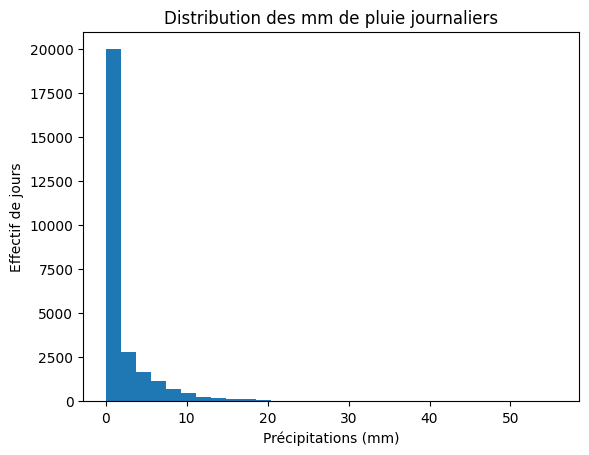

In [8]:
import matplotlib.pyplot as plt
plt.hist(daily["precip_mm"], bins=30)
plt.title("Distribution des mm de pluie journaliers")
plt.xlabel("Précipitations (mm)")
plt.ylabel("Effectif de jours")
plt.show()

Evolution temporelle du volume de pluie

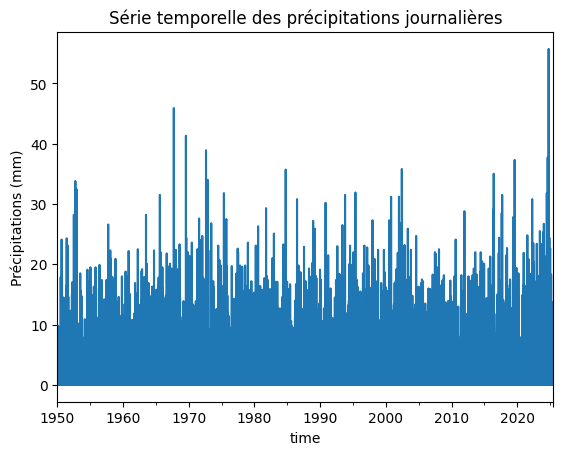

In [10]:
daily["precip_mm"].plot()
plt.title("Série temporelle des précipitations journalières")
plt.ylabel("Précipitations (mm)")
plt.show()

Part des journées avec pluie vs sans pluie

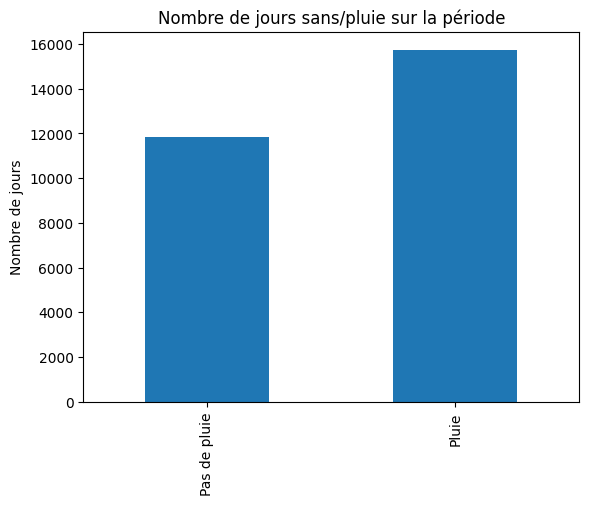

In [11]:
counts = daily["rain_binary"].value_counts().sort_index()
counts.index = ["Pas de pluie", "Pluie"]
counts.plot(kind="bar")
plt.title("Nombre de jours sans/pluie sur la période")
plt.ylabel("Nombre de jours")
plt.show()

In [13]:
daily = df.resample("D").agg({
    "precipitation": "sum",
    "temperature_2m": "mean",
    "relativehumidity_2m": "mean",
    "pressure_msl": "mean"
}).rename(columns={
    "precipitation": "precip_mm",
    "temperature_2m": "temp_mean",
    "relativehumidity_2m": "rh_mean",
    "pressure_msl": "press_mean"
})
daily["rain_binary"] = (daily["precip_mm"] > 0).astype(int)

Feature Engineering

In [15]:
import numpy as np

daily["precip_lag1"] = daily["precip_mm"].shift(1)
daily["temp_lag1"]   = daily["temp_mean"].shift(1)
daily["rh_lag1"]     = daily["rh_mean"].shift(1)
daily["press_lag1"]  = daily["press_mean"].shift(1)

daily["month"] = daily.index.month
daily["month_sin"] = np.sin(2 * np.pi * daily["month"] / 12)
daily["month_cos"] = np.cos(2 * np.pi * daily["month"] / 12)

daily = daily.dropna()

daily.head()

,precip_mm,temp_mean,rh_mean,press_mean,rain_binary,precip_lag1,temp_lag1,rh_lag1,press_lag1,month,month_sin,month_cos
time,,,,,,,,,,,,
1950-01-02,0.2,0.595833,82.875000,1028.920833,1,0.0,-0.925000,73.875000,1029.737500,1,0.5,0.866025
1950-01-03,0.3,9.250000,95.416667,1017.895833,1,0.2,0.595833,82.875000,1028.920833,1,0.5,0.866025
1950-01-04,0.4,9.337500,90.500000,1015.187500,1,0.3,9.250000,95.416667,1017.895833,1,0.5,0.866025
1950-01-05,0.5,8.125000,91.791667,1013.220833,1,0.4,9.337500,90.500000,1015.187500,1,0.5,0.866025
1950-01-06,0.9,6.362500,85.250000,1013.791667,1,0.5,8.125000,91.791667,1013.220833,1,0.5,0.866025


RandomForest avec features météo + saison

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

feature_cols = [
    "precip_lag1",
    "temp_lag1",
    "rh_lag1",
    "press_lag1",
]
X = daily[feature_cols]
y = daily["rain_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63      2392
           1       0.72      0.75      0.73      3123

    accuracy                           0.69      5515
   macro avg       0.69      0.68      0.68      5515
weighted avg       0.69      0.69      0.69      5515

ROC AUC: 0.744893989678478


In [19]:
feature_cols = [
    "precip_lag1",
    "temp_lag1",
    "rh_lag1",
    "press_lag1",
    "month_sin",
    "month_cos"
]
X = daily[feature_cols]
y = daily["rain_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.67      0.62      0.65      2392
           1       0.73      0.76      0.74      3123

    accuracy                           0.70      5515
   macro avg       0.70      0.69      0.69      5515
weighted avg       0.70      0.70      0.70      5515

ROC AUC: 0.7595065524209742


Belle amélioration !

Variante	ROC AUC
Sans encodage cyclique	0.7449
Avec sin/cos	0.7595

C’est un gain d’environ 1,5 point d’AUC juste en représentant correctement la saisonnalité – ça vaut clairement le coup de conserver cet encodage !

Rolling 3‑jours

In [20]:
daily["temp_3d_ma"]     = daily["temp_mean"].rolling(3).mean().shift(1)
daily["rh_3d_ma"]       = daily["rh_mean"].rolling(3).mean().shift(1)
daily["press_3d_ma"]    = daily["press_mean"].rolling(3).mean().shift(1)
daily["precip_3d_sum"]  = daily["precip_mm"].rolling(3).sum().shift(1)

Heavy‑rain flag

In [21]:
daily["heavy_rain_lag1"] = (daily["precip_mm"].shift(1) > 20).astype(int)

In [22]:
daily = daily.dropna()

In [23]:
feature_cols = [
    "precip_lag1",
    "temp_lag1",
    "rh_lag1",
    "press_lag1",
    "month_sin",
    "month_cos",
    "temp_3d_ma",
    "rh_3d_ma",
    "press_3d_ma",
    "precip_3d_sum",
    "heavy_rain_lag1"
]
X = daily[feature_cols]
y = daily["rain_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66      2392
           1       0.73      0.78      0.76      3123

    accuracy                           0.72      5515
   macro avg       0.71      0.70      0.71      5515
weighted avg       0.71      0.72      0.71      5515

ROC AUC: 0.771823733075456


On observe un nouveau bond de performance :

Accuracy passée de 0.70 → 0.72

ROC AUC de 0.7595 → 0.7718

C’est un gain non négligeable (+1.2 point d’AUC) simplement en incorporant les moyennes glissantes et le flag “heavy rain”.

Interprétation

1) Rolling 3 jours lisse suffisamment le bruit quotidien pour capter la persistance météo.

2) Heavy rain lag1 signale efficacement les épisodes intenses qui souvent précèdent un front pluvieux.

3) On reste sur un RandomForest, qui exploite bien ces variables continues et binaires.

Création de nouvelles features rolling (5 et 7 jours)

In [26]:
for window in [5, 7]:
    daily[f"temp_{window}d_ma"]    = daily["temp_mean"].rolling(window).mean().shift(1)
    daily[f"rh_{window}d_ma"]      = daily["rh_mean"].rolling(window).mean().shift(1)
    daily[f"press_{window}d_ma"]   = daily["press_mean"].rolling(window).mean().shift(1)
    daily[f"precip_{window}d_sum"] = daily["precip_mm"].rolling(window).sum().shift(1)

daily = daily.dropna()
daily.head()

,precip_mm,temp_mean,rh_mean,press_mean,rain_binary,precip_lag1,temp_lag1,rh_lag1,press_lag1,month,...,precip_3d_sum,heavy_rain_lag1,temp_5d_ma,rh_5d_ma,press_5d_ma,precip_5d_sum,temp_7d_ma,rh_7d_ma,press_7d_ma,precip_7d_sum
time,,,,,,,,,,,,,,,,,,,,,
1950-01-12,0.3,7.466667,94.375000,1034.666667,1,0.0,5.654167,97.916667,1033.116667,1,...,0.5,0,4.983333,91.825000,1022.523333,0.9,5.629167,90.880952,1019.947024,2.3
1950-01-13,0.0,5.675000,90.916667,1029.783333,0,0.3,7.466667,94.375000,1034.666667,1,...,0.8,0,5.325833,92.916667,1025.860833,0.8,5.535119,91.250000,1023.010714,2.1
1950-01-14,0.0,5.725000,90.916667,1030.795833,0,0.0,5.675000,90.916667,1029.783333,1,...,0.3,0,5.820833,94.091667,1028.064167,0.8,5.436905,92.059524,1025.295238,1.2
1950-01-15,0.1,6.516667,83.750000,1029.229167,1,0.0,5.725000,90.916667,1030.795833,1,...,0.3,0,6.233333,94.125000,1031.005000,0.8,5.432738,92.345238,1027.126190,0.8
1950-01-16,9.8,5.716667,90.083333,1016.891667,1,0.1,6.516667,83.750000,1029.229167,1,...,0.1,0,6.207500,91.575000,1031.518333,0.4,5.906548,92.160714,1028.620833,0.9


Entraînement d'un XGBoost avec ces nouvelles features

In [27]:
import xgboost as xgb

feature_cols = [
    "precip_lag1", "temp_lag1", "rh_lag1", "press_lag1",
    "temp_3d_ma", "rh_3d_ma", "press_3d_ma", "precip_3d_sum",
    "temp_5d_ma", "rh_5d_ma", "press_5d_ma", "precip_5d_sum",
    "temp_7d_ma", "rh_7d_ma", "press_7d_ma", "precip_7d_sum",
    "month_sin", "month_cos"
]

X = daily[feature_cols]
y = daily["rain_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "seed": 42
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=10,
    verbose_eval=False
)

y_prob = bst.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66      2392
           1       0.73      0.79      0.76      3121

    accuracy                           0.72      5513
   macro avg       0.72      0.71      0.71      5513
weighted avg       0.72      0.72      0.72      5513

ROC AUC: 0.7788874776436245


Précision & recall du positif sont légèrement améliorés (recall 0.78 → 0.79), ce qui veut dire qu’on capte un peu mieux les jours de pluie.

ROC AUC à 0.7789 confirme que le modèle distingue plus finement les cas pluie/non‑pluie.

Importance des features

In [28]:
importance_dict = bst.get_score(importance_type="gain")

feat_imp = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "gain": list(importance_dict.values())
}).sort_values("gain", ascending=False)

feat_imp["gain_pct"] = 100 * feat_imp["gain"] / feat_imp["gain"].sum()

feat_imp.reset_index(drop=True, inplace=True)
feat_imp.head(10)

,feature,gain,gain_pct
0,precip_lag1,142.949005,52.423976
1,press_lag1,29.168804,10.697134
2,precip_3d_sum,9.179576,3.366444
3,temp_lag1,7.379223,2.706197
4,rh_3d_ma,6.647816,2.437967
5,month_cos,6.642698,2.436090
6,rh_5d_ma,6.480343,2.376549
7,rh_lag1,6.466847,2.371600
8,temp_5d_ma,6.423798,2.355812
9,rh_7d_ma,6.158223,2.258417


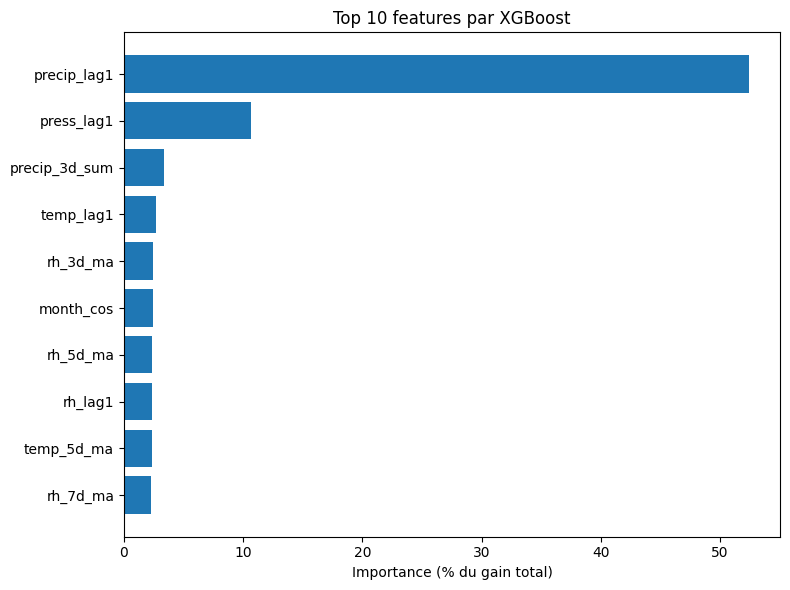

In [29]:
top_n = 10
plt.figure(figsize=(8, 6))
plt.barh(feat_imp["feature"].iloc[:top_n][::-1], feat_imp["gain_pct"].iloc[:top_n][::-1])
plt.xlabel("Importance (% du gain total)")
plt.title(f"Top {top_n} features par XGBoost")
plt.tight_layout()
plt.show()

Sélection des features par importance

In [33]:
selected = feat_imp.loc[feat_imp["gain_pct"] > 2.5, "feature"].tolist()
print("Features retenues :", selected)

Features retenues : ['precip_lag1', 'press_lag1', 'precip_3d_sum', 'temp_lag1']


In [31]:
X = daily[selected]
y = daily["rain_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "seed": 42
}

bst_sel = xgb.train(
    params,
    dtrain,
    num_boost_round=bst.best_iteration,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=False
)

y_prob_sel = bst_sel.predict(dtest)
y_pred_sel = (y_prob_sel > 0.5).astype(int)

print(classification_report(y_test, y_pred_sel))
print("ROC AUC:", roc_auc_score(y_test, y_prob_sel))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65      2392
           1       0.73      0.79      0.76      3121

    accuracy                           0.71      5513
   macro avg       0.71      0.70      0.70      5513
weighted avg       0.71      0.71      0.71      5513

ROC AUC: 0.775195795769086


In [36]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier



X = daily[selected]
y = daily["rain_binary"]

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="auc", seed=42)

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X, y)

print("Meilleurs paramètres :", search.best_params_)
print("Meilleur score CV (AUC) :", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Meilleur score CV (AUC) : 0.7745815534231023


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:28:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Notre exploration d’hyper‑paramètres XGBoost (subsample=0.6, n_estimators=50, max_depth=3, learning_rate=0.05, colsample_bytree=0.8) n’a pas dépassé l’AUC de 0.775 obtenue précédemment. On conclut donc que la version XGBoost + feature importance reste notre meilleur compromis performance/complexité.

Bilan de la phase Modélisation

Baseline (precip uniquement) : AUC ≈ 0.745

Ajout sin/cos mois : AUC ≈ 0.760

Rolling 3 j + heavy‑rain + RF : AUC ≈ 0.772

XGBoost + rolling 5/7 j : AUC ≈ 0.779

XGBoost + feature importance: AUC ≈ 0.775

Hyper‑paramétrage XGBoost : AUC ≈ 0.774

Interface

In [37]:
import joblib
joblib.dump(bst_sel, 'model.bst')

['model.bst']

In [ ]:
!pip install ipywidgets xgboost

In [51]:
%pip install -q colabcode
from google.colab import output
output.enable_custom_widget_manager()

import joblib
bst = joblib.load("model.bst")

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import xgboost as xgb

precip_lag1_w   = widgets.FloatText(value=0.0, description='Précip hier (mm):')
press_lag1_w    = widgets.FloatText(value=1013.0, description="Pression hier (hPa):")
precip_3d_sum_w = widgets.FloatText(value=0.0, description="Somme 3j pluie (mm):")
temp_lag1_w     = widgets.FloatText(value=15.0, description="Temp hier (°C):")
btn = widgets.Button(description="Prédire pluie demain")

out = widgets.Output()

def on_predict(b):
    with out:
        clear_output()
        df = pd.DataFrame([{
            "precip_lag1": precip_lag1_w.value,
            "press_lag1": press_lag1_w.value,
            "precip_3d_sum": precip_3d_sum_w.value,
            "temp_lag1": temp_lag1_w.value
        }])
        dmat = xgb.DMatrix(df)
        prob = bst.predict(dmat)[0]
        print(f"→ Probabilité de pluie demain : {prob:.2%}")

btn.on_click(on_predict)

ui = widgets.VBox([
    precip_lag1_w,
    press_lag1_w,
    precip_3d_sum_w,
    temp_lag1_w,
    btn,
    out
])
display(ui)